<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%8C%8C%EB%A8%B8%EC%99%84ch09_1~4_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기한: 11월 10일 (금) 18:30

파이썬 머신러닝 완벽가이드 ch9. 1~4

pg. 562~579 필사하여 깃허브에 업로드한 뒤, 깃허브 링크를 댓글로 달아주세요.

# 09. 추천 시스템

### 01. 추천 시스템의 개요와 배경

**추천시스템의 개요**
* 아마존, 이베이 등 전자상거래 업체 큰 매출 향상

**온라인 스토어의 필수 요소, 추천 시스템**
* 사용자가 원하는걸 빠르게 찾아냄
  * 사용자가 어떤 상품을 구매?
  * 어떤 상품 둘러보고, 장바구니?
  * 영화 평점? 제품 평가?
  * 사용자 취향
  * 클릭

**추천 시스템의 유형**
* 콘텐츠 기반 필터링
* 협업 필터링
  * 최근접 이웃
  * 잠재요인

### 02. 콘텐츠 기반 필터링 추천 시스템
: 사용자가 특정 아이템 매우 선호 시, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템 추천

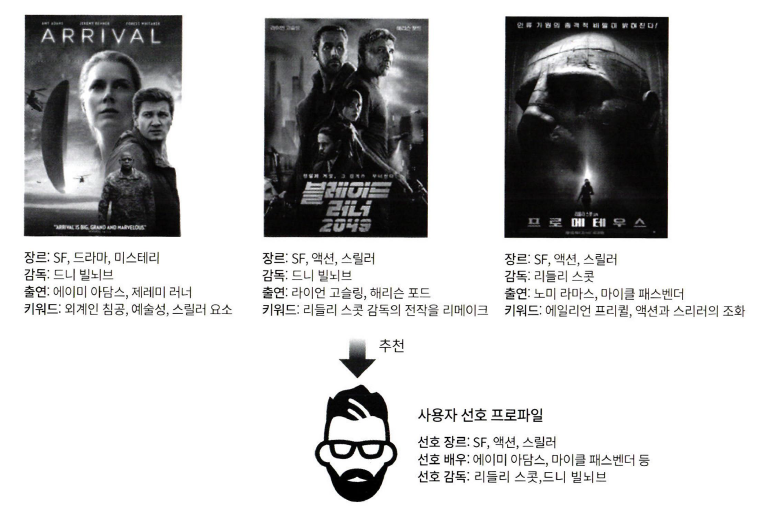

### 03. 최근접 이웃 협업 필터링(=메모리 협업 필터링)
: 사용자가 아이템에 매긴 평점, 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천

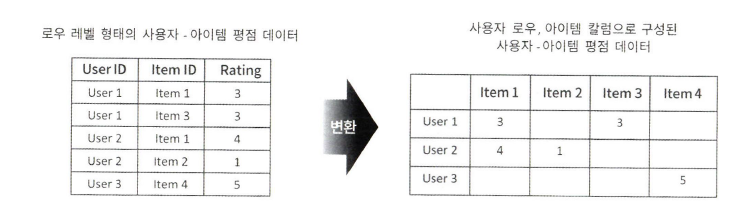

* 사용자 기반
* 아이템 기반

### 04. 잠재 요인 협업 필터링

**잠재 요인 협업 필터링 이해**
* 사용자-아이템 평점 행렬 데이터만을 이용해 잠재요인을 끄집어 내는 것
* 사용자가 아직 평점을 부여하지 않는 아이템에 대한 예측 평점 생성

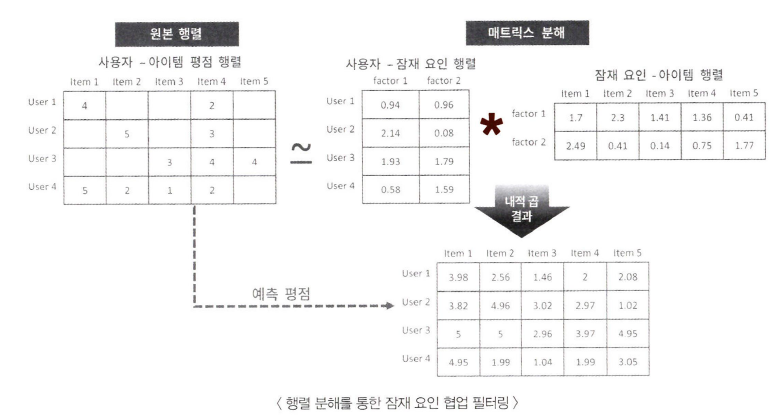

**행렬 분해 이해**
* 다차원의 매트릭스-> 저차원 분해 기법
* SVD
* NMF

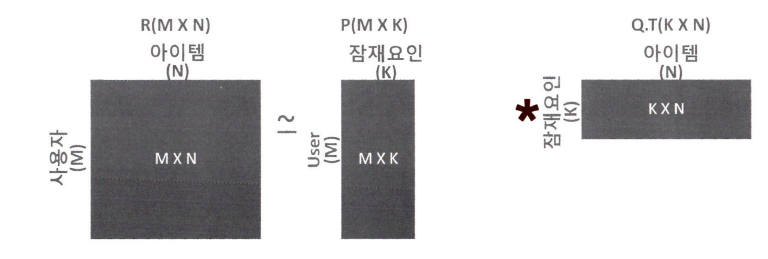

**확률적 경사 하강법을 이용한 행렬 분해**
* P, Q 행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P와 Q를 유추해내는 것

1. P와 Q를 임의의 값을 가진 행렬로 설정
2. P와 Q,T의 값을 곱해 예측 R 행렬 계산 -> 예측 R 행렬과 실제 R 행렬 오류 값 계산
3. 오류값 최소화하는 P,Q 업데이트
4. 만족 오류값 가질때까지 2,3 반복 -> P,Q 값 업데이트해 근사화

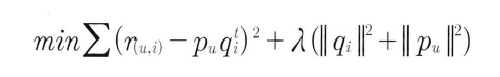

### ex. SGD 이용해 행렬 분해 수행

In [1]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재 요인 차원 K는 3으로 설정
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
              [np.NaN, 5, np.NaN, 3, 1],
              [np.NaN, np.NaN, 3, 4, 4],
              [5, 2, 1, 2, np.NaN]])
num_users, num_items = R.shape
K=3

# P와 Q 행렬의 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

In [2]:
# 실제 R 행렬과 예측 행렬의 오차를 구하는 함수 생성
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [3]:
# SGD 기반으로 행렬 분해 수행

# R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장
non_zeros = [ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0 ]

steps = 1000
learning_rate = 0.01
r_lambda = 0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
for step in range(steps):
  for i, j, r in non_zeros:
    # 실제 값과 예측 값의 차이인 오류 값 구함
    eij = r - np.dot(P[i, :], Q[j, :].T)
    # Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
    Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])
  rmse = get_rmse(R, P, Q, non_zeros)
  if (step % 50) == 0:
    print('### iteration step:', step, 'rmse:', rmse)

### iteration step: 0 rmse: 3.2388050277987723
### iteration step: 50 rmse: 0.4876723101369648
### iteration step: 100 rmse: 0.1564340384819247
### iteration step: 150 rmse: 0.07455141311978046
### iteration step: 200 rmse: 0.04325226798579314
### iteration step: 250 rmse: 0.029248328780878973
### iteration step: 300 rmse: 0.022621116143829466
### iteration step: 350 rmse: 0.019493636196525135
### iteration step: 400 rmse: 0.018022719092132704
### iteration step: 450 rmse: 0.01731968595344266
### iteration step: 500 rmse: 0.016973657887570753
### iteration step: 550 rmse: 0.016796804595895633
### iteration step: 600 rmse: 0.01670132290188466
### iteration step: 650 rmse: 0.01664473691247669
### iteration step: 700 rmse: 0.016605910068210026
### iteration step: 750 rmse: 0.016574200475705
### iteration step: 800 rmse: 0.01654431582921597
### iteration step: 850 rmse: 0.01651375177473524
### iteration step: 900 rmse: 0.01648146573819501
### iteration step: 950 rmse: 0.016447171683479155


In [4]:
# 분해된 P와 Q 함수를 P * Q.T로 예측 행렬 만들어 출력
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


> 원본 행렬과 비교해 널 아닌 값은 큰 차이가 나지 않음, 널인 값은 새로운 예측값으로 채워짐